Re-starting from epoch 20
Object 1:
  Class: drone
  Bounding box: [   0  350 1024 1024]
  Confidence score: 1.0


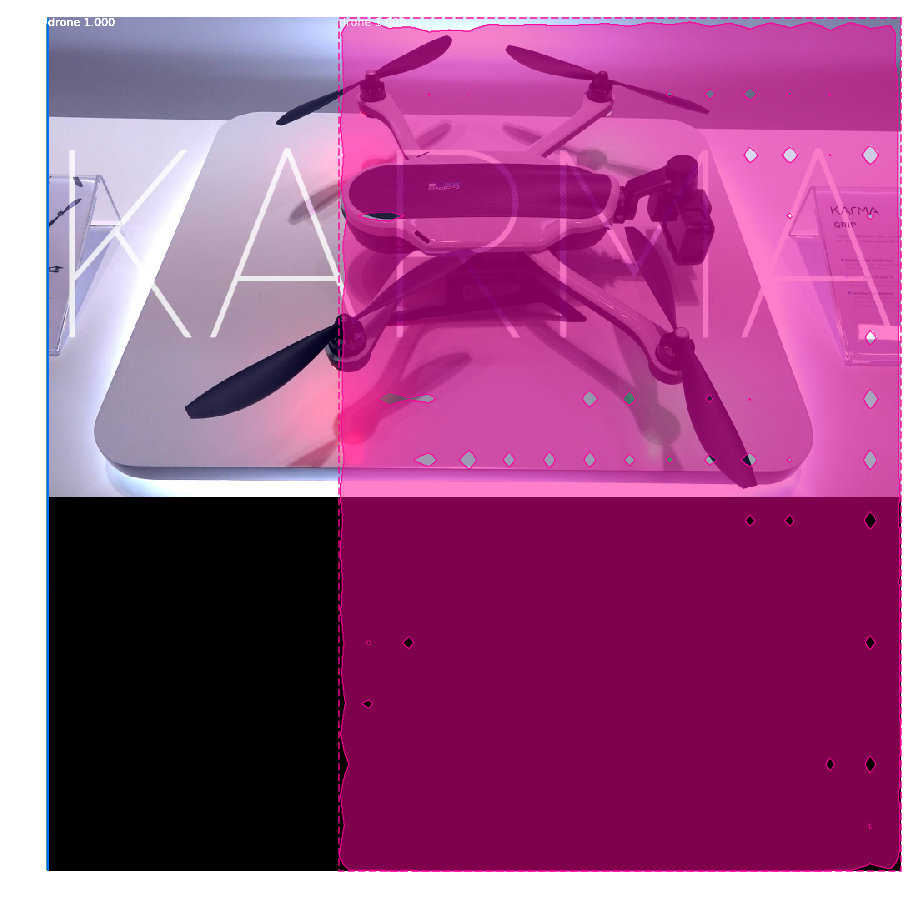

In [12]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import numpy as np
import random

# Class names
CLASS_NAMES = ['BG', 'drone']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"

    # Set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes = number of classes + 1 (+1 for the background).
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
model = mrcnn.model.MaskRCNN(mode="inference",
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath="logs\drone_detection20241123T1349\mask_rcnn_drone_detection_0020.h5", by_name=True)

# Directory for validation images
validation_dir = "dataset/validation"
image_files = [f for f in os.listdir(validation_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image file from the list
random_image_file = random.choice(image_files)

# Load the input image, convert it from BGR to RGB channel
image = cv2.imread(os.path.join(validation_dir, random_image_file))

# Resize the image while maintaining aspect ratio
height, width = image.shape[:2]
scale = 1024 / max(height, width)
resized_image = cv2.resize(image, (int(width * scale), int(height * scale)))

# Pad the image to 1024x1024 if needed
padded_image = np.zeros((1024, 1024, 3), dtype=np.uint8)
padded_image[:resized_image.shape[0], :resized_image.shape[1]] = resized_image

# Check if the image was loaded properly
if padded_image is None:
    print("Error: Unable to load image. Check the file path.")
else:
    padded_image = cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([padded_image])[0]

CONFIDENCE_THRESHOLD = 0.4  # Adjusted threshold
MIN_BOX_AREA = 100  # Minimum box area

# Filter indices of detections with scores higher than the threshold
high_confidence_indices = [i for i, score in enumerate(r['scores']) if score > CONFIDENCE_THRESHOLD]

# Loop through detections and filter based on confidence and bounding box size
for i in range(len(r['scores'])):
    y1, x1, y2, x2 = r['rois'][i]
    box_height = y2 - y1
    box_width = x2 - x1
    box_area = box_height * box_width
    
    if r['scores'][i] > CONFIDENCE_THRESHOLD and box_area > MIN_BOX_AREA:
        print(f"Object {i + 1}:")
        print(f"  Class: {CLASS_NAMES[r['class_ids'][i]]}")
        print(f"  Bounding box: {r['rois'][i]}")  # y1, x1, y2, x2
        print(f"  Confidence score: {r['scores'][i]}")
        # Break after the first detected drone
        break
    else:
        print(f"Filtered out Object {i + 1} with tiny bounding box or low confidence.")

# Visualize only the high-confidence detections
if len(high_confidence_indices) > 0:
    mrcnn.visualize.display_instances(image=padded_image,  # Use padded_image for visualization
                                      boxes=r['rois'][high_confidence_indices],
                                      masks=r['masks'][:, :, high_confidence_indices],
                                      class_ids=r['class_ids'][high_confidence_indices],
                                      class_names=CLASS_NAMES,
                                      scores=r['scores'][high_confidence_indices])
else:
    print("No high-confidence detections found.")
